In [203]:
using DataFrames
using RDatasets
using Statistics
using StatsPlots
using CSV
using StatsBase
using NamedArrays
using PrettyTables
using DecisionTree
using Shuffle
using Plots.PlotMeasures

include(joinpath(dirname(pwd()), "plottraintest.jl"))

fsize = 5
ftsize = 5

5

In [204]:
function mse(ŷ::Vector{T}, y::Vector{T})::T where T<:AbstractFloat
	mean((ŷ .- y).^2)
end

mse (generic function with 1 method)

In [205]:
df = CSV.read(joinpath(dirname(pwd()), "Concrete_Data.csv"), DataFrame)

Row,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Compressive strength (MPa)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
2,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
4,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
5,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.3
6,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.7
8,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
9,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85


In [206]:
dfm = Matrix(df)
dfms = dfm[shuffle(1:end), :]
# dfms = dfm

x = dfms[:, 1:8]
y = dfms[:, 9]

data_split = [0.6, 0.3, 0.1]
split_cs2 = Int.(round.(cumsum(data_split)*length(y)))
split_cs1 = vcat(1, split_cs2[1:(end-1)].+1)

xtrain = x[split_cs1[1]:split_cs2[1], :]
ytrain = y[split_cs1[1]:split_cs2[1]]

xtest = x[split_cs1[2]:split_cs2[2], :]
ytest = y[split_cs1[2]:split_cs2[2]]

xval = x[split_cs1[3]:split_cs2[3], :]
yval = y[split_cs1[3]:split_cs2[3]];

In [207]:
# set of regression parameters and respective default values
# pruning_purity: purity threshold used for post-pruning (default: 1.0, no pruning)
# max_depth: maximum depth of the decision tree (default: -1, no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 5)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)
# n_subfeatures: number of features to select at random (default: 0, keep all)
# keyword rng: the random number generator or seed to use (default Random.GLOBAL_RNG)
n_subfeatures = 0; max_depth = -1; min_samples_leaf = 5
min_samples_split = 2; min_purity_increase = 0.0; pruning_purity = 1.0 ; seed=rand(1:1000)

model = build_tree(ytrain, xtrain,
                   n_subfeatures,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split,
                   min_purity_increase;
                   rng = seed)

Decision Tree
Leaves: 95
Depth:  10

In [208]:
# To avoid overfitting
model = prune_tree(model, 0.9)

Decision Tree
Leaves: 95
Depth:  10

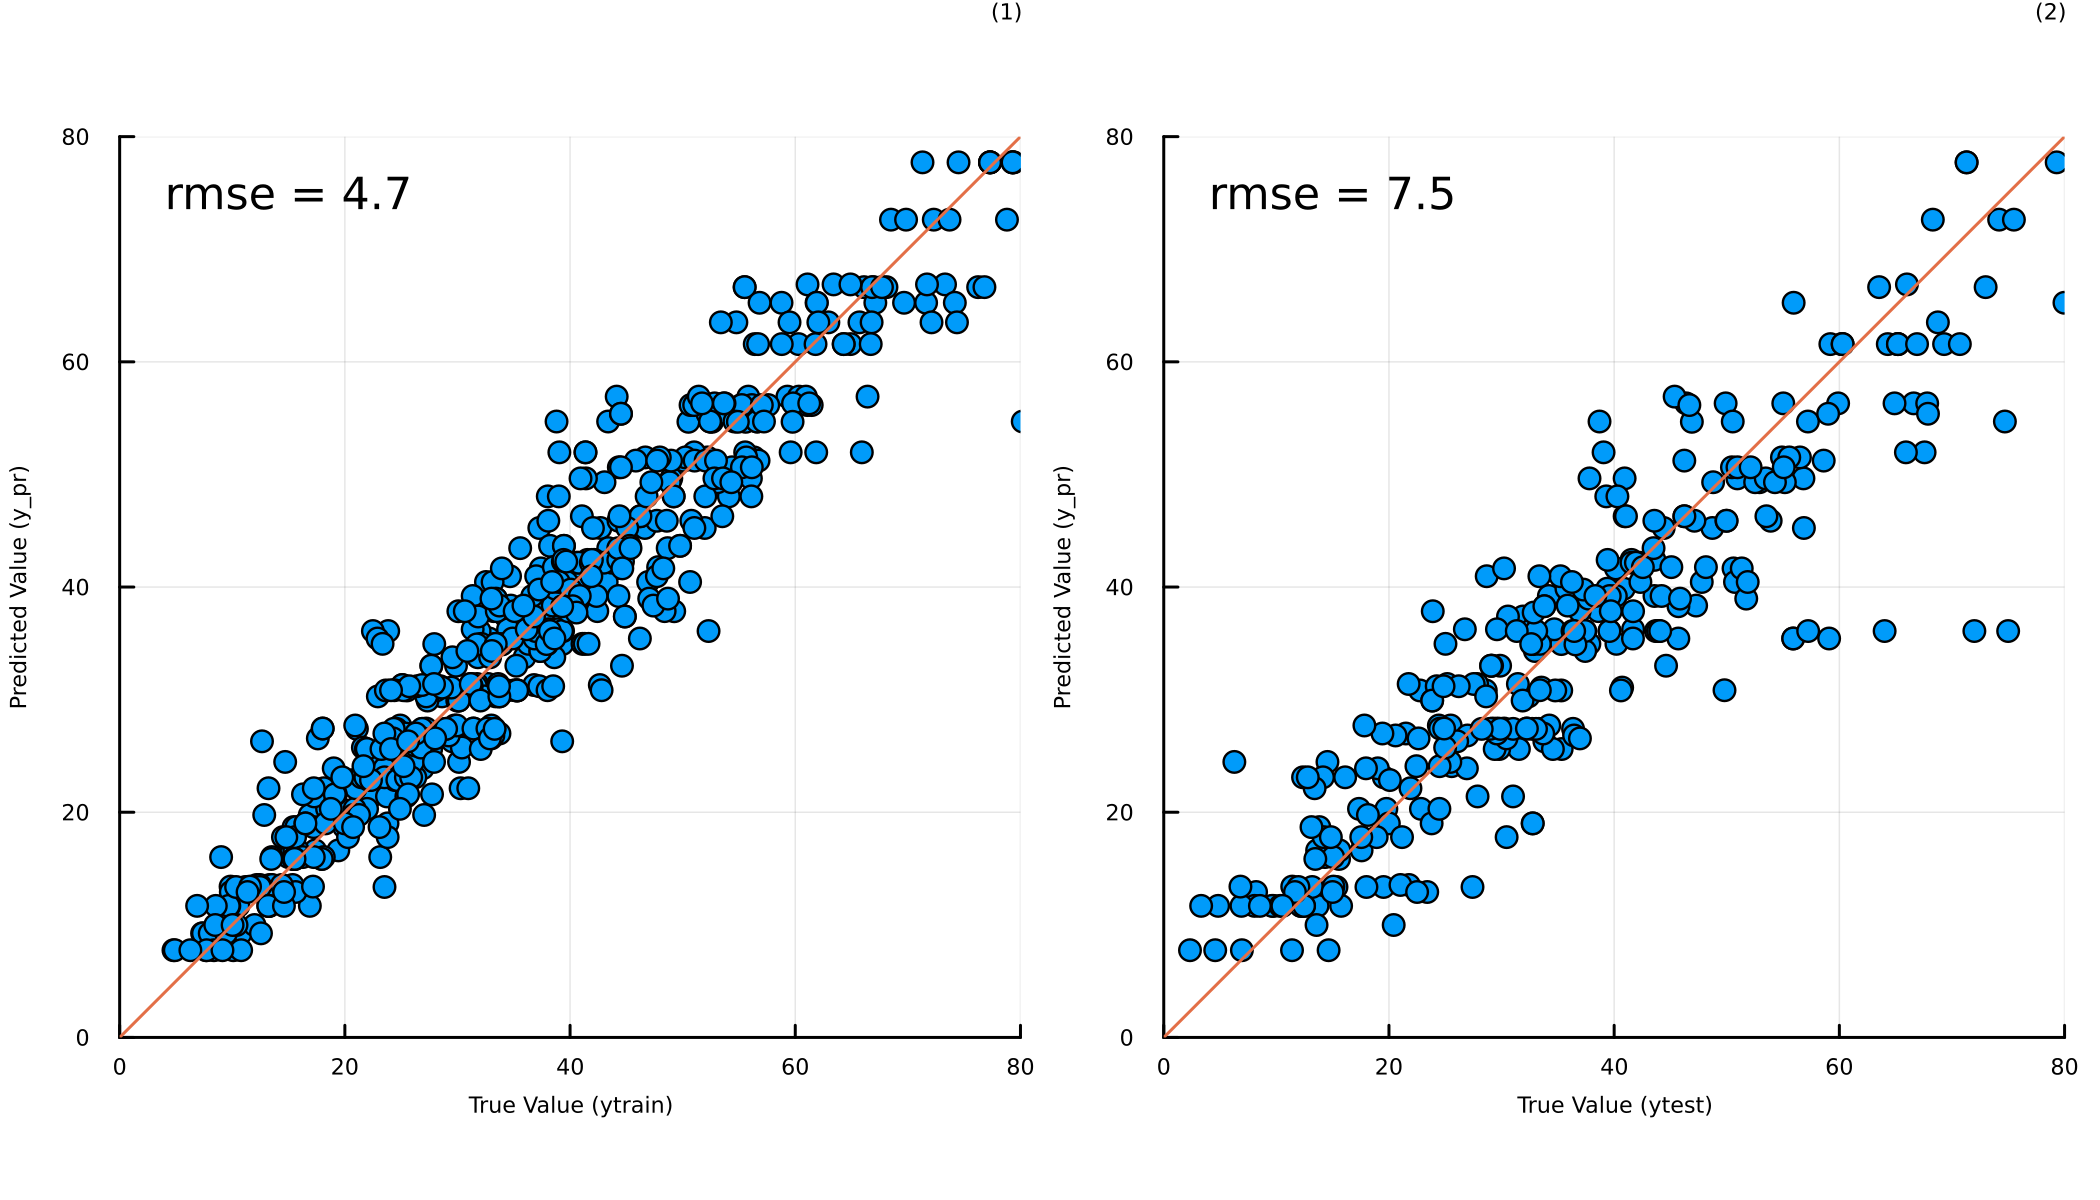

In [209]:
# apply learned model
y_pr_train = apply_tree(model, xtrain)
y_pr_test = apply_tree(model, xtest)

display(plottraintest(ytrain, y_pr_train, ytest, y_pr_test))
# savefig(joinpath(dirname(@__FILE__), "Tree.png"))

In [210]:
xmean = mean(x, dims=1)
ymean = mean(y, dims=1)
xstd = std(x, dims=1)
ystd = std(y, dims=1)

ytrainnorm = (ytrain.-ymean)./ystd
xtrainnorm = (xtrain.-xmean)./xstd

ytestnorm = (ytest.-ymean)./ystd
xtestnorm = (xtest.-xmean)./xstd

# build tree for normalized values
model_norm = build_tree(ynorm, xnorm,
                   n_subfeatures,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split,
                   min_purity_increase;
                   rng = seed)

Decision Tree
Leaves: 96
Depth:  11

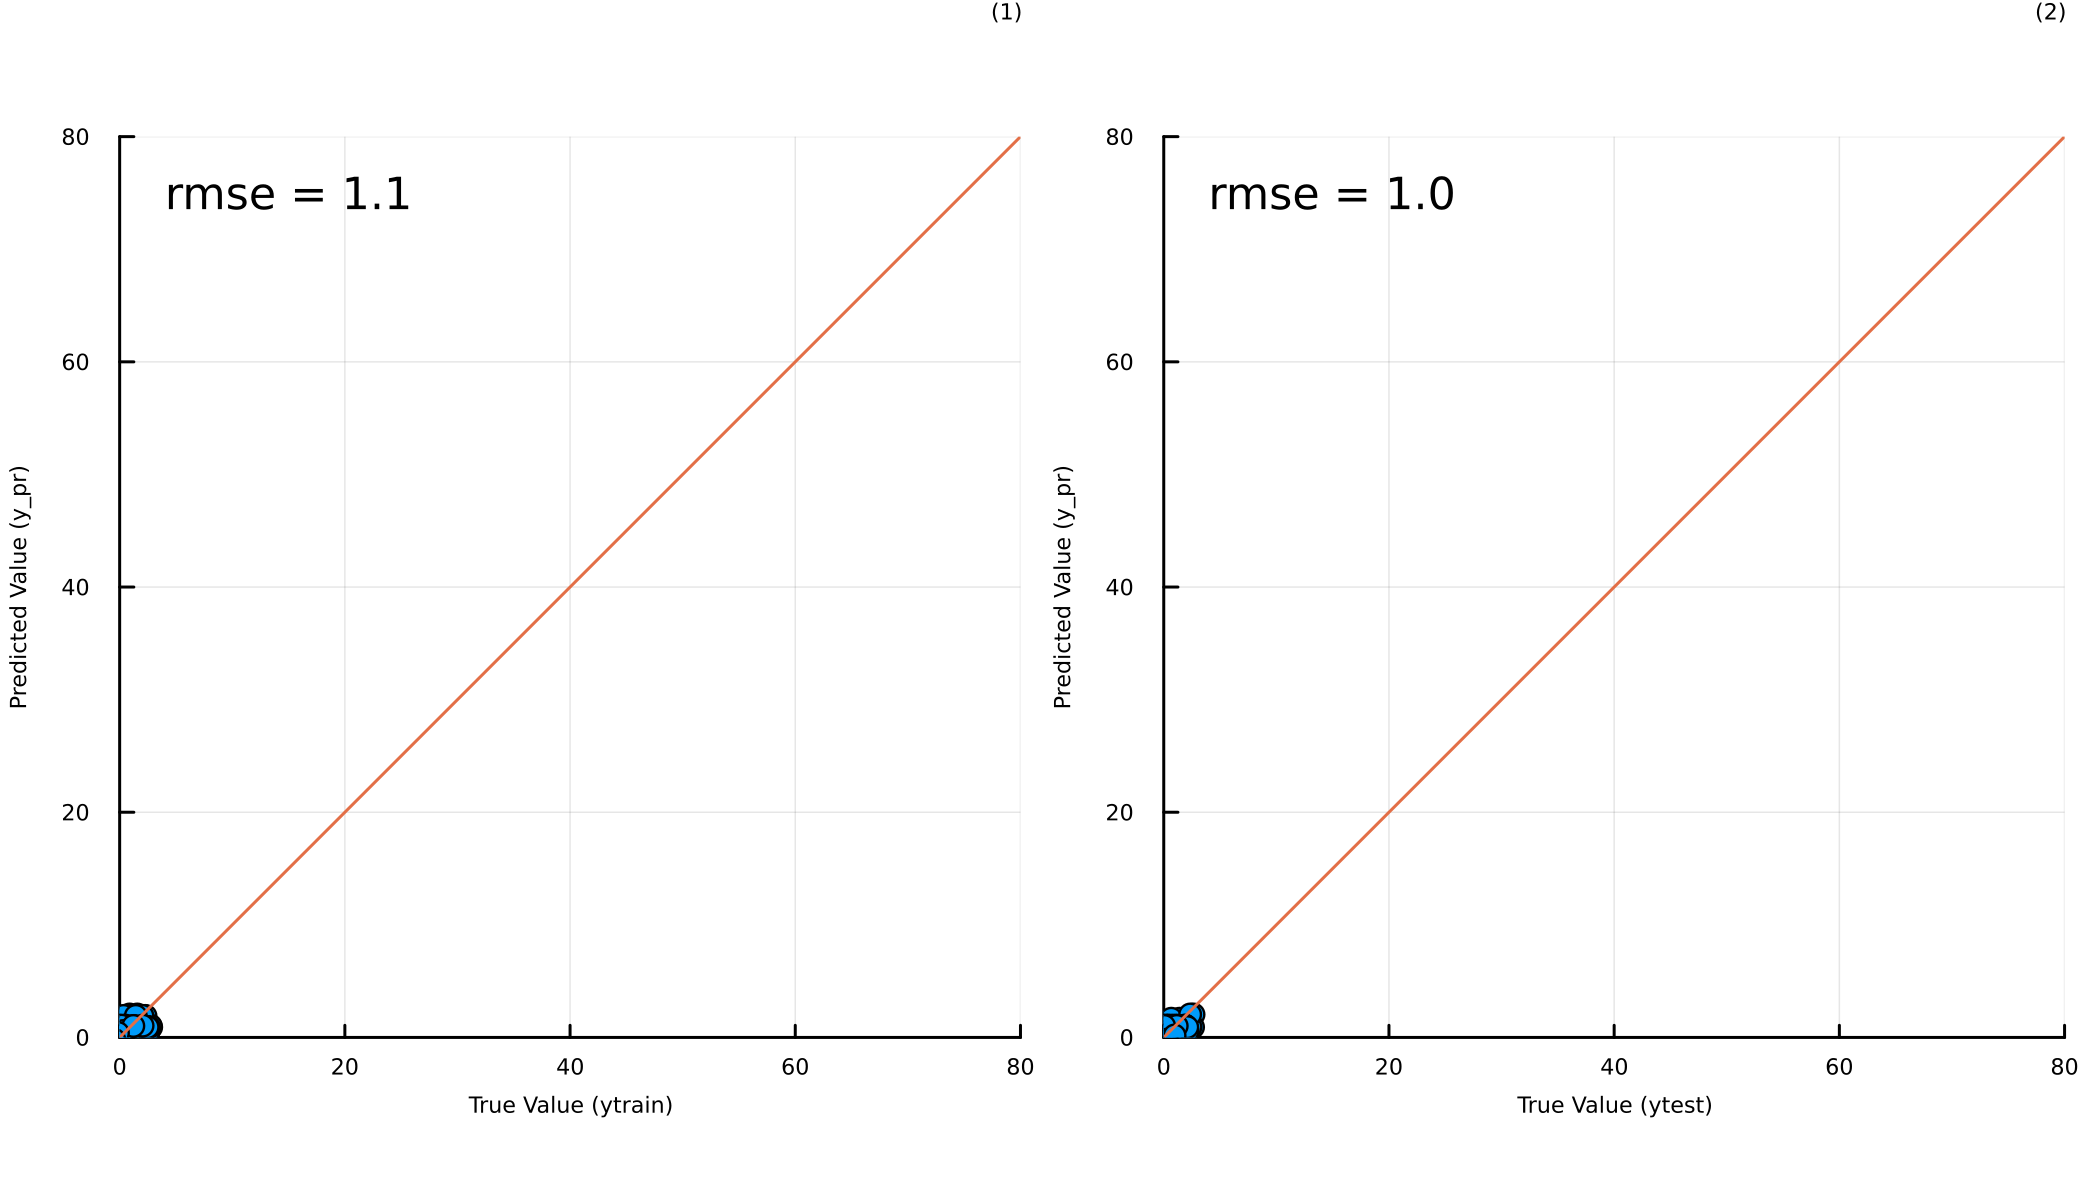

In [211]:
# apply learned model
y_pr_trainnorm = apply_tree(model_norm, xtrainnorm)
y_pr_testnorm = apply_tree(model_norm, xtestnorm)

display(plottraintest(ytrainnorm, y_pr_trainnorm, ytestnorm, y_pr_testnorm))
# savefig(joinpath(dirname(@__FILE__), "Tree.png"))

In [212]:
r2 = nfoldCV_tree(ytrain, xtrain, 3)


Fold 1
Mean Squared Error:     65.41067440784605
Correlation Coeff:      0.8779343232156637
Coeff of Determination: 0.764794222792847

Fold 2
Mean Squared Error:     78.52648210292354
Correlation Coeff:      0.8516390289490605
Coeff of Determination: 0.7081028957210077

Fold 3
Mean Squared Error:     54.266810144770616
Correlation Coeff:      0.8962216908227795
Coeff of Determination: 0.7980603144026653

Mean Coeff of Determination: 0.7569858109721733


3-element Vector{Float64}:
 0.764794222792847
 0.7081028957210077
 0.7980603144026653

In [213]:
# set of regression build_forest() parameters and respective default values
# n_subfeatures: number of features to consider at random per split (default: -1, sqrt(# features))
# n_trees: number of trees to train (default: 10)
# partial_sampling: fraction of samples to train each tree on (default: 0.7)
# max_depth: maximum depth of the decision trees (default: no maximum)
# min_samples_leaf: the minimum number of samples each leaf needs to have (default: 5)
# min_samples_split: the minimum number of samples in needed for a split (default: 2)
# min_purity_increase: minimum purity needed for a split (default: 0.0)
# keyword rng: the random number generator or seed to use (default Random.GLOBAL_RNG)
#              multi-threaded forests must be seeded with an `Int`
n_subfeatures=-1; n_trees=10; partial_sampling=0.7; max_depth=-1
min_samples_leaf=5; min_samples_split=2; min_purity_increase=0.0; seed=rand(1:1000)
model_forest = build_forest(ytrain, xtrain,
                     n_subfeatures,
                     n_trees,
                     partial_sampling,
                     max_depth,
                     min_samples_leaf,
                     min_samples_split,
                     min_purity_increase;
                     rng = seed)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 68.5
Avg Depth:  11.5

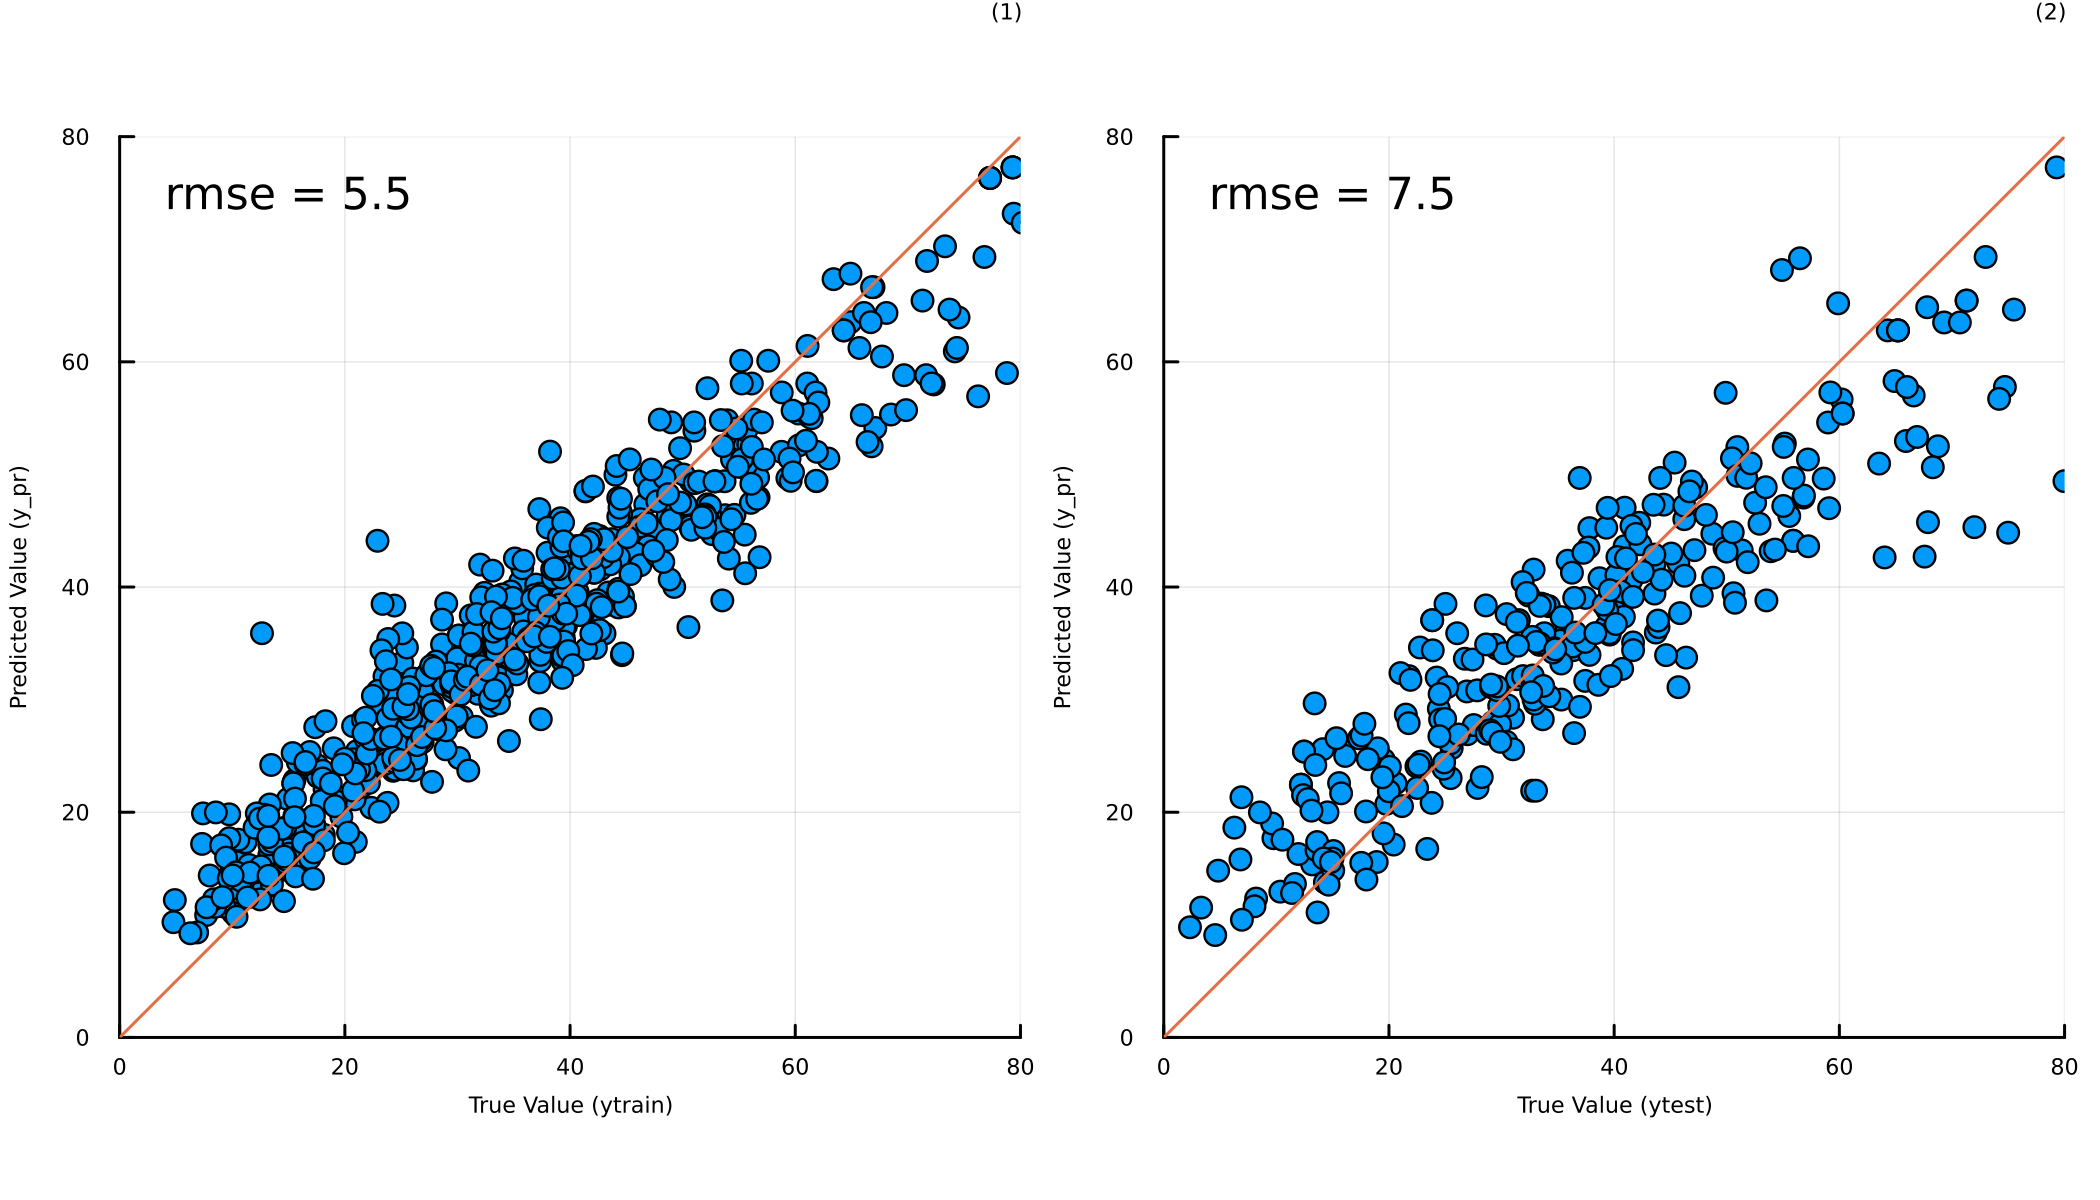

In [214]:
# apply learned model
y_pr_train = apply_forest(model_forest, xtrain)
y_pr_test = apply_forest(model_forest, xtest)

display(plottraintest(ytrain, y_pr_train, ytest, y_pr_test))
# savefig(joinpath(dirname(@__FILE__), "Forest.png"))

In [215]:
r2 = nfoldCV_forest(ytrain, xtrain, 3)


Fold 1
Mean Squared Error:     68.69265029627881
Correlation Coeff:      0.8805538561103334
Coeff of Determination: 0.7602922141771238

Fold 2
Mean Squared Error:     65.4919566032995
Correlation Coeff:      0.8658777156916926
Coeff of Determination: 0.7432493834242045

Fold 3
Mean Squared Error:     57.776779620733066
Correlation Coeff:      0.9028113625230549
Coeff of Determination: 0.7999434829855029

Mean Coeff of Determination: 0.7678283601956104


3-element Vector{Float64}:
 0.7602922141771238
 0.7432493834242045
 0.7999434829855029